## Fluctuation test

A question that has emerged a number of times in evolutionary analysis is whether mutation rates vary, and specifically whether they vary in response to a selection pressure. In particular, do mutations emerge as a result of a stressor or do they occur during the growth of the culture? Even more controversially: does the likelihood of an advantageous mutation increase when bacteria are subjected to some stressor (e.g. antibiotic, bacteriophage, etc.)? For a bit of a history of this problem you can consult https://en.wikipedia.org/wiki/Luria%E2%80%93Delbr%C3%BCck_experiment

In the 1940's Salvatore Luria (experimental biologist) and Max Delbrück (physicist) designed an experiment to distinguish whether mutations arose pre or post-stressor. The experiment was the following: bacterial cultures were grown independently from small inocula. After some period of growth, equal volumes of these cultures were plated at low density onto agar containing the T1 phage, so that only resistant bacteria will end up forming small, visible colonies that could be counted. 

What is the expected distribution of the number of resistant bacteria on a plate if the virus **induced** resistance?

What is the expected distribution if the virus **selected** the resistant bacteria from the population that was plated?

Implement a simulation of this experiment: 
- grow populations of bacteria from a single cell to a specified final number
- consider implementing an event-driven simulation, where cell divisions occur and the time to division can be chosen from a variety of distributions when a cell is born
- implement mutations (mutation rate a parameter) at cell division
- implement the phenotype check (resistant/sensitive)
- derive the distribution of the number of mutants per culture
- explore the form of the distribution when mutations are induced or selected
- explore the form of the distribution for different lifespan distributions (what distribution of lifespans did Luria and Delbrück assume in their model?)

In [32]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from abc import abstractmethod

from attr import dataclass
from enum import Enum
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

from heapq import heapify, heappush, heappop

In [33]:
class Phenotype(Enum):
    Resistant = 0,
    Sensitive = 1,

class Cell:
    Phenotype: Phenotype = Phenotype.Sensitive

    def __init__(self, phenotype: Phenotype):
        self.Phenotype = phenotype

    def __lt__(self, other):
        return True

class Param:
    mutation_rate_res: float = 0.1
    mutation_rate_ses: float = 0.01

In [34]:

# Abstract class to allow for undefined distribution passing to grow function
class Distribution:
    @abstractmethod
    def sample(self) -> int:
        pass

# Specific distribution implementations
class Poisson(Distribution):
    mean: float

    def __init__(self, mean: float):
        self.mean = mean

    def sample(self) -> float:
        return sp.stats.poisson.rvs(self.mean)

In [35]:
def divide(cell: Cell, mutationrate: float, spontaneous: bool) -> (Cell, Cell):
    new_phenotype: Phenotype = cell.Phenotype
    if spontaneous and mutationrate > np.random.rand():
        if cell.Phenotype == Phenotype.Sensitive:
            new_phenotype = Phenotype.Resistant
    return Cell(new_phenotype), Cell(new_phenotype)

# Simulate growth of cell culture
def grow(population_size: int, dist: Distribution, mutationrate: float, spontaneous: bool, MAXTIME = 10000) -> list[Cell]:
    population: list[Cell] = [Cell(Phenotype.Sensitive)]

    # Stack for cells which can be divided
    ready_population_stack: list[Cell] = []

    # Min Heap for next cell to be divided by time
    heap: list[(int, Cell)] = []
    heapify(heap)
    t: int = 0

    # Initialize first Cell in heap
    heappush(heap, (dist.sample(), population[0]))

    # Simulation
    while len(population) < population_size:
        # Divide parent cell
        dt, p = heappop(heap)
        t = dt
        population.remove(p)
        c1, c2 = divide(p, mutationrate, spontaneous)

        # Add children to population
        population.append(c1)
        population.append(c2)

        # Allow cells to divide again
        heappush(heap, (t + dist.sample(), c1))
        heappush(heap, (t + dist.sample(), c2))

    while len(population) != population_size:
        population.remove(np.random.choice(population))

    return population

In [36]:
def count_population(population: list[Cell]) -> [int, int]:
    counts: [int, int] = [0, 0]
    for p in population:
        if p.Phenotype == Phenotype.Sensitive:
            counts[0] += 1
        else:
            counts[1] += 1
    return counts

In [37]:
total_counts_sensitive_induced = []
total_counts_resistant_induced = []

total_counts_sensitive_spontaneous = []
total_counts_resistant_spontaneous = []

mutation_rate = 0.1

for i in range(100):
    counts = count_population(grow(1000, Poisson(5), mutation_rate, True))
    total_counts_sensitive_spontaneous.append(counts[0])
    total_counts_resistant_spontaneous.append(counts[1])

for i in range(100):
    population = grow(1000, Poisson(5), mutation_rate, False)
    counts = [0, 0]
    for p in population:
        if np.random.rand() < mutation_rate:
            counts[1] += 1
        else:
            counts[0] += 1

    total_counts_sensitive_induced.append(counts[0])
    total_counts_resistant_induced.append(counts[1])

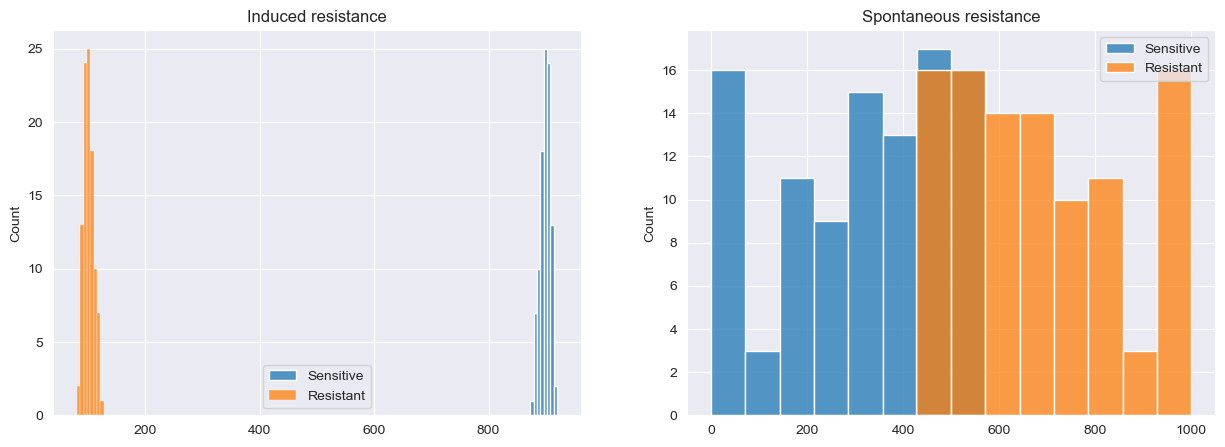

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(total_counts_sensitive_induced, ax=ax1, label="Sensitive")
sns.histplot(total_counts_resistant_induced, ax=ax1, label="Resistant")
ax1.set_title("Induced resistance")
sns.histplot(total_counts_sensitive_spontaneous, ax=ax2, label="Sensitive")
sns.histplot(total_counts_resistant_spontaneous, ax=ax2, label="Resistant")
ax2.set_title("Spontaneous resistance")
ax1.legend()
ax2.legend()
plt.show()